## 목차
- [1. 경진대회 이해](#1-경진대회-이해)
- [2. 탐색적 데이터 분석](#2-탐색적-데이터-분석)
  * [2.1. 데이터 둘러보기](#21-데이터-둘러보기)
  * [2.2. 데이터 시각화](#22-데이터-시각화)
- [3. 베이스라인 모델](#3-베이스라인-모델)
  * [3.1. 피쳐 엔지니어링](#31-피쳐-엔지니어링)
  * [3.2. 모델 훈련](#32-모델-훈련)
  * [3.3. 모델 성능 검증](#33-모델-성능-검증)
  * [3.4. 예측 및 결과 제출](#34-예측-및-결과-제출)
- [4. 성능 개선 1](#4-성능-개선-1)
  * [4.1. 피쳐 엔지니어링 1 : 피쳐 맞춤 인코딩](#41-피쳐-엔지니어링-1--피쳐-맞춤-인코딩)
  * [4.2. 피쳐 엔지니어링 2 : 피쳐 스케일링](#42-피쳐-엔지니어링-2--피쳐-스케일링)
  * [4.3. 하이퍼파라미터 최적화](#43-하이퍼파라미터-최적화)
  * [4.4. 모델 성능 검증](#44-모델-성능-검증)
  * [4.5. 예측 및 결과 제출](#45-예측-및-결과-제출)
- [5. 성능 개선 2](#5-성능-개선-2)
- [6. 학습 마무리](#6-학습-마무리)
  * [6.1. 핵심 요약](#61-핵심-요약)

In [34]:
import warnings

warnings.filterwarnings(action='ignore') 

<a name="1-경진대회-이해"></a>
# 1. 경진대회 이해

<a name="2-탐색적-데이터-분석"></a>
# 2. 탐색적 데이터 분석

<a name="21-데이터-둘러보기"></a>
## 2.1. 데이터 둘러보기

In [252]:
import pandas as pd

data_path = './dataset/cat-in-the-dat/'

train = pd.read_csv(data_path+'train.csv', index_col='id')
test = pd.read_csv(data_path+'test.csv', index_col='id')
submission = pd.read_csv(data_path+'sample_submission.csv', index_col='id')

In [102]:
train.head(2).T

id,0,1
bin_0,0,0
bin_1,0,1
bin_2,0,0
bin_3,T,T
bin_4,Y,Y
nom_0,Green,Green
nom_1,Triangle,Trapezoid
nom_2,Snake,Hamster
nom_3,Finland,Russia
nom_4,Bassoon,Piano


binary, norminal, ordinal, date까지 총 4종류의 타입이 존재하며 각 타입의 개념에 유의하여 피쳐엔지니어링을 진행해야한다.

In [103]:
def resumetable(df):
    summary = pd.DataFrame(df.dtypes, columns=['type'])
    summary = summary.reset_index()
    summary = summary.rename(columns={'index':'피쳐'})
    summary['결측치'] = df.isnull().sum().values
    summary['고유값'] = df.nunique().values
    summary['임의값'] = df.loc[0].values

    return summary

resumetable(train)

,피쳐,type,결측치,고유값,임의값
0,bin_0,int64,0,2,0
1,bin_1,int64,0,2,0
2,bin_2,int64,0,2,0
3,bin_3,object,0,2,T
4,bin_4,object,0,2,Y
5,nom_0,object,0,3,Green
6,nom_1,object,0,6,Triangle
7,nom_2,object,0,6,Snake
8,nom_3,object,0,6,Finland
9,nom_4,object,0,4,Bassoon


In [104]:
for i in range(3):
    feature = 'ord_' + str(i)
    print(f'{feature} : {train[feature].unique()}')

ord_0 : [2 1 3]
ord_1 : ['Grandmaster' 'Expert' 'Novice' 'Contributor' 'Master']
ord_2 : ['Cold' 'Hot' 'Lava Hot' 'Boiling Hot' 'Freezing' 'Warm']


<a name="22-데이터-시각화"></a>
## 2.2. 데이터 시각화

In [105]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

<Axes: xlabel='target', ylabel='count'>

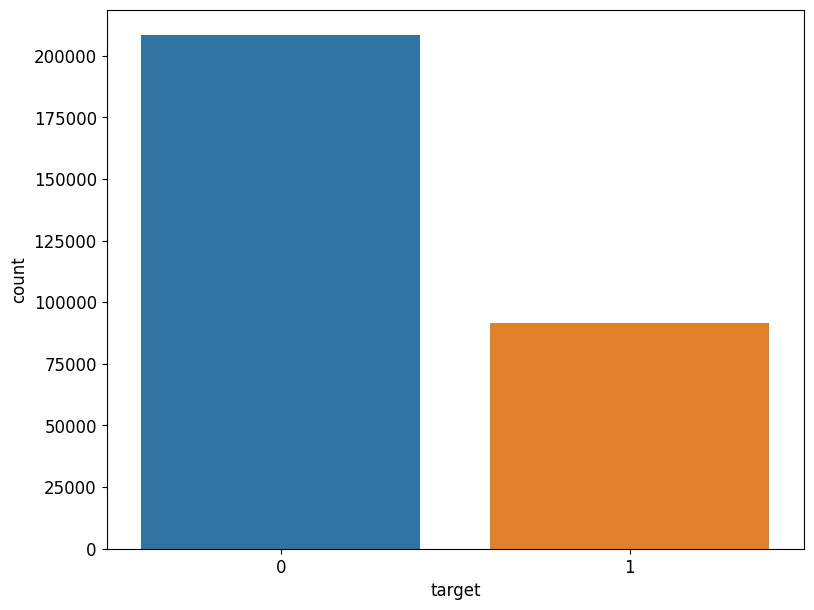

In [106]:
fig = plt.figure(figsize=(9,7))

fig = sns.countplot(train, x='target')
fig

In [107]:
print(fig.patches[0], fig.patches[1])

Rectangle(xy=(-0.4, 0), width=0.8, height=208236, angle=0) Rectangle(xy=(0.6, 0), width=0.8, height=91764, angle=0)


In [108]:
fig.patches[0].get_x()

-0.4

Text(0.5, 1.0, 'Target Dist')

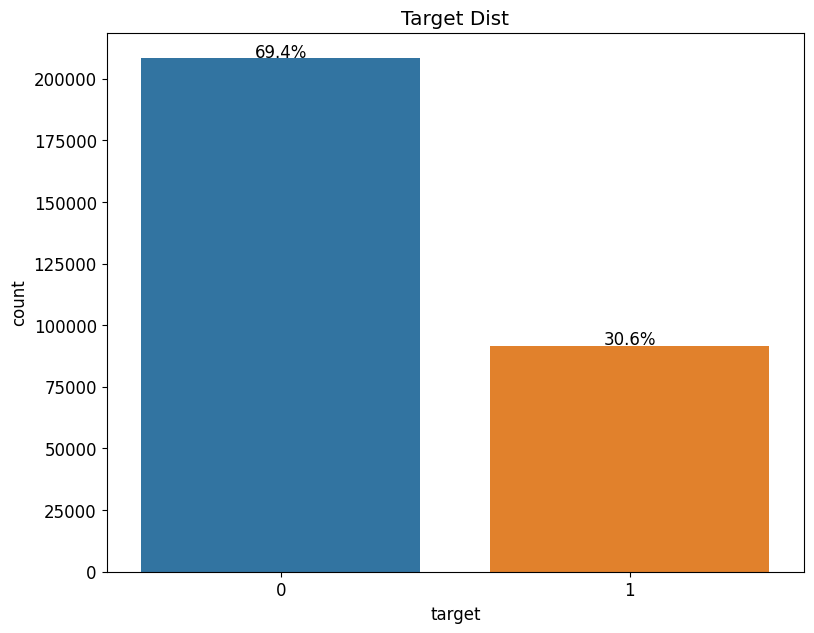

In [132]:
def write_percent(fig, total_size):
    for patch in fig.patches:
        height = patch.get_height()
        width = patch.get_width()
        left_coord = patch.get_x()
        percent = height/total_size*100

        fig.text(x=left_coord + width/2,
                 y=height + total_size*0.001,
                 s=f'{percent:1.1f}%',
                 ha='center'
                )
fig = plt.figure(figsize=(9,7))

fig = sns.countplot(train, x='target')
write_percent(fig, len(train))
fig.set_title('Target Dist')

<a name="이진형-피쳐"></a>
### 이진형 피쳐

countplot에서 hue 옵션이 int형을 받아 들이지를 못하는 이슈

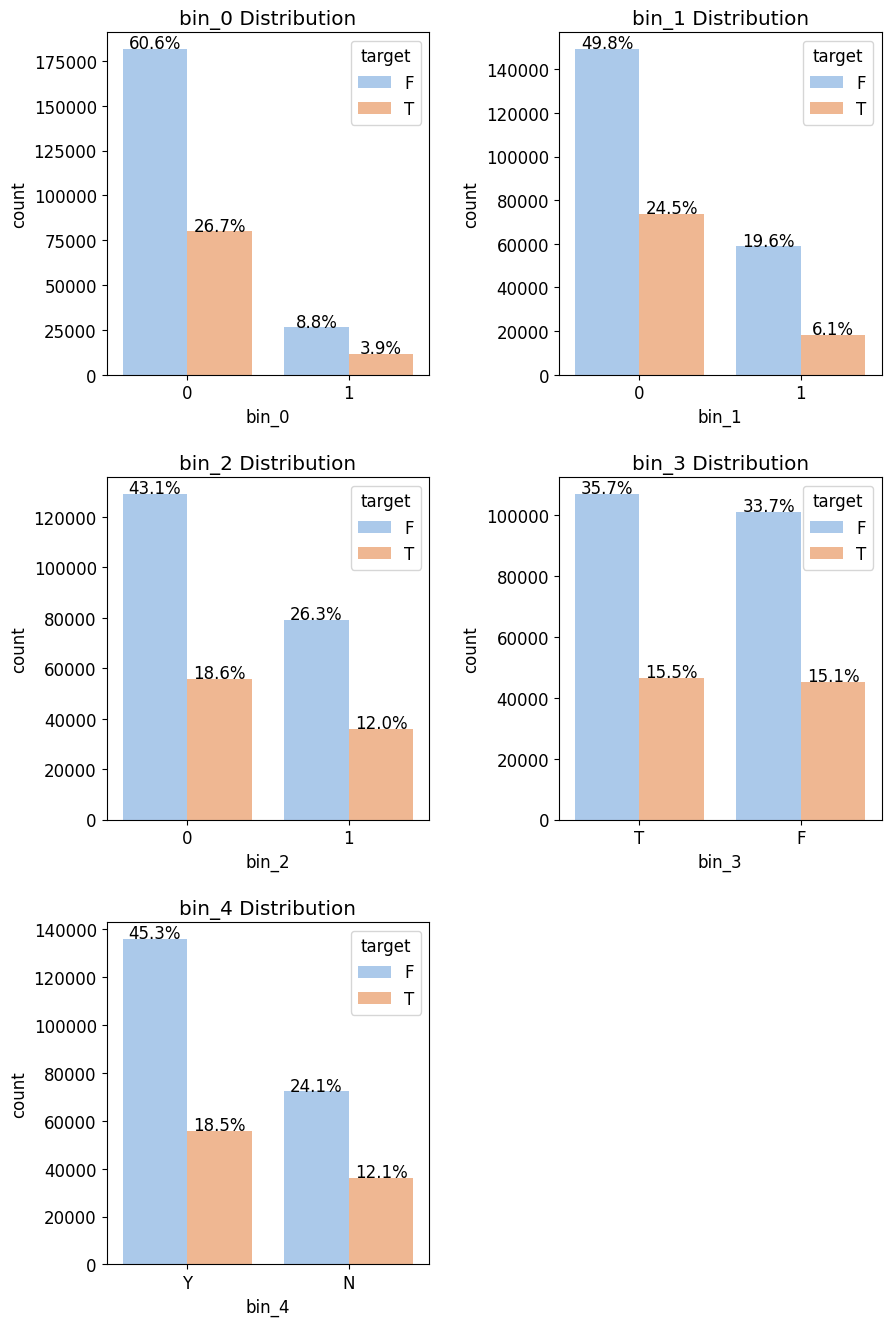

In [131]:
import matplotlib.gridspec as gridspec

mpl.rc('font', size=12)
grid = gridspec.GridSpec(3,2)
plt.figure(figsize=(10,16))
plt.subplots_adjust(wspace=0.4, hspace=0.3)

bin_feat = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4']

t_train = train.copy()
t_train['target'] = t_train['target'].map({0:'F', 1:'T'})

for idx, feature in enumerate(bin_feat):
    fig = plt.subplot(grid[idx])

    sns.countplot(
        x=feature,
        data=t_train,
        hue='target',
        palette='pastel',
        ax=fig
    )

    fig.set_title(f'{feature} Distribution')
    write_percent(fig, len(train))

<a name="명목형-피쳐"></a>
### 명목형 피쳐

교차 분석표 생성

In [135]:
pd.crosstab(train['nom_0'], train['target'])

target,0,1
nom_0,,
Blue,72914,23252
Green,85682,41659
Red,49640,26853


In [161]:
crosstab = pd.crosstab(train['nom_0'], train['target'], normalize='index')*100
crosstab

target,0,1
nom_0,,
Blue,75.820976,24.179024
Green,67.285478,32.714522
Red,64.894827,35.105173


In [225]:
def get_crosstab(df, feature):
    crosstab = pd.crosstab(df[feature], df['target'], normalize='index')*100
    crosstab = crosstab.reset_index()
    return crosstab

In [226]:
dd = get_crosstab(train, 'nom_0')
dd

target,nom_0,0,1
0,Blue,75.820976,24.179024
1,Green,67.285478,32.714522
2,Red,64.894827,35.105173


포인트플롯 생성

In [235]:
def plot_pointplot(ax, feature, crosstab, train):
    # sns.countplot(data=train, x=feature, order=crosstab[feature].values, ax=ax)
    ax2 = ax.twinx()
    ax2 = sns.pointplot(x=feature, y=1, data=crosstab, order=crosstab[feature].values)
    ax2.set_ylabel('Target Ratio(%)')

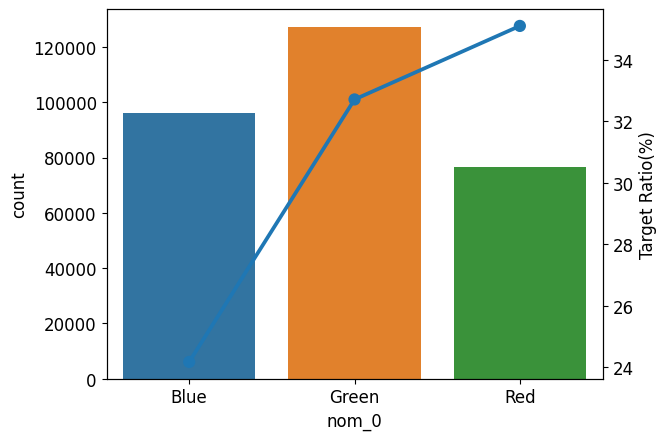

In [234]:
import matplotlib.gridspec as gridspec

mpl.rc('font', size=12)
grid = gridspec.GridSpec(1,1)

ax = plt.subplot(grid[0])
plot_pointplot(ax, 'nom_0', get_crosstab(train, 'nom_0'), train)

피쳐 분포도 및 포인트 플롯 생성

In [240]:
def plot_ratio(df, features, num_rows, num_cols, size=(15,20)):
    plt.figure(figsize=size)
    grid = gridspec.GridSpec(num_rows,num_cols)
    plt.subplots_adjust(wspace=0.45, hspace=0.3)

    for idx, feature in enumerate(features):
        ax = plt.subplot(grid[idx])
        crosstab = get_crosstab(df, feature)

        sns.countplot(x=feature, data=df,
                     order=crosstab[feature].values,
                     color='skyblue',
                     ax=ax)

        write_percent(ax, len(df))
        plot_pointplot(ax, feature, crosstab, df)
        ax.set_title(f'{feature} Dis')

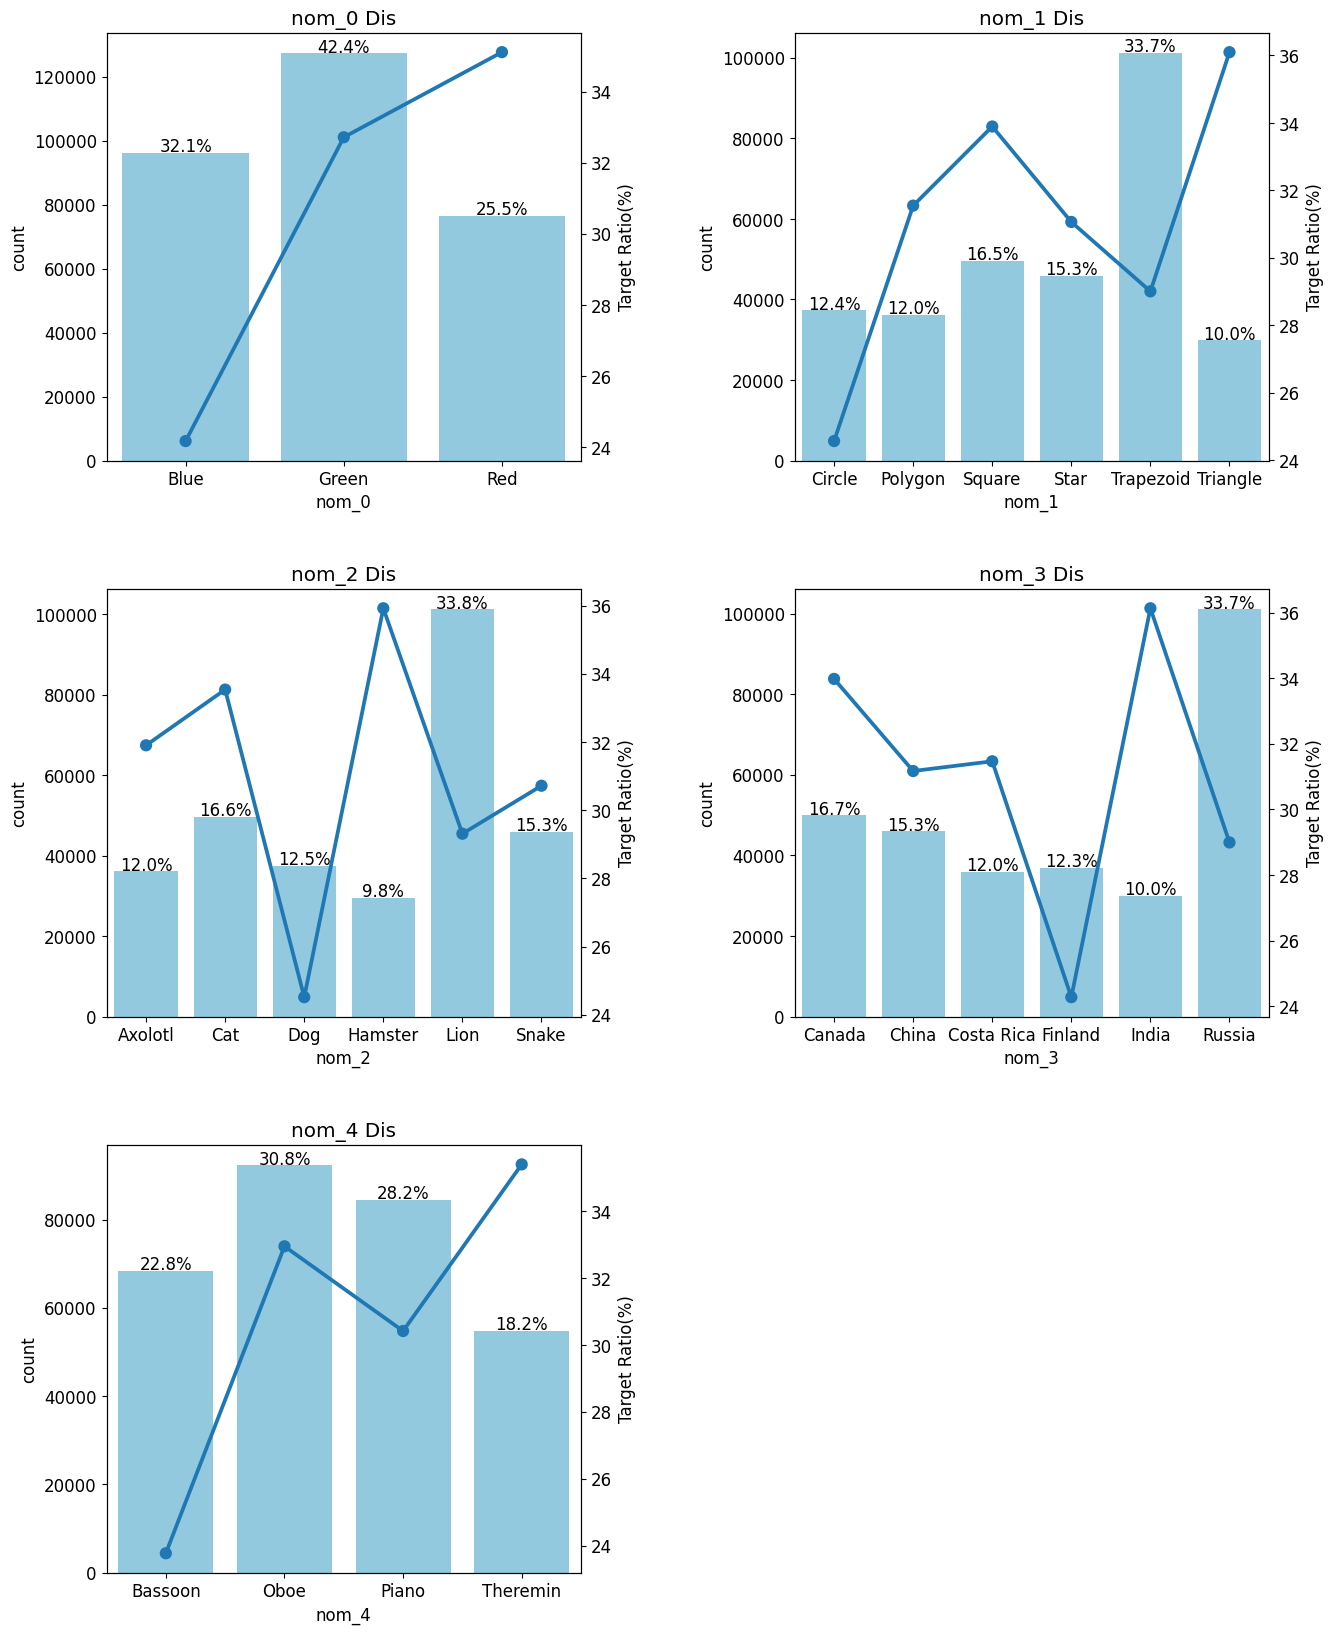

In [242]:
nom_feature = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']
plot_ratio(train, nom_feature, num_rows=3, num_cols=2)

<a name="순서형-피쳐"></a>
### 순서형 피쳐

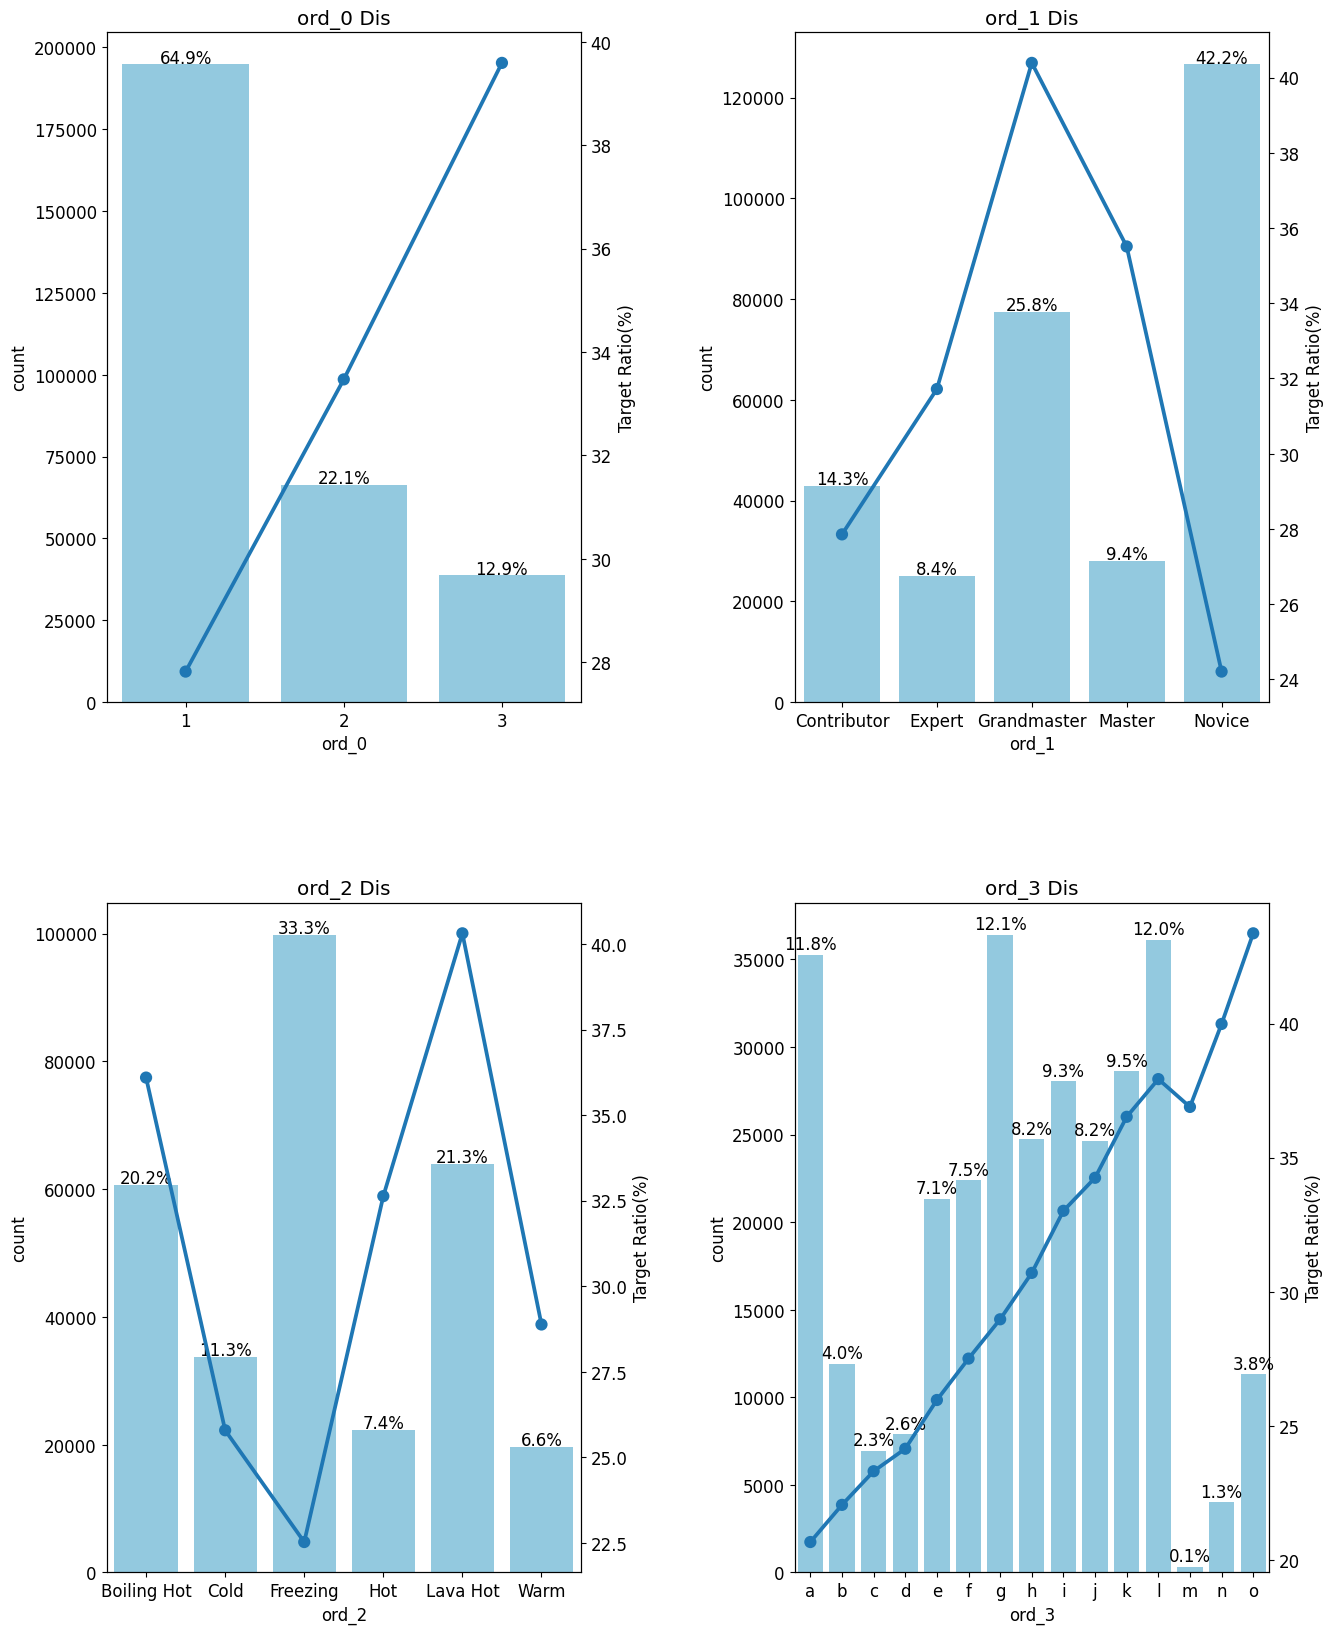

In [244]:
nom_feature = ['ord_0', 'ord_1', 'ord_2', 'ord_3']
plot_ratio(train, nom_feature, num_rows=2, num_cols=2)

In [253]:
from pandas.api.types import CategoricalDtype

ord_1_value = ['Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster']
ord_2_value = ['Freezing', 'Cold', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot']

ord_1_dtype = CategoricalDtype(categories=ord_1_value, ordered=True)
ord_2_dtype = CategoricalDtype(categories=ord_2_value, ordered=True)

train['ord_1'] = train['ord_1'].astype(ord_1_dtype)
train['ord_2'] = train['ord_2'].astype(ord_2_dtype)

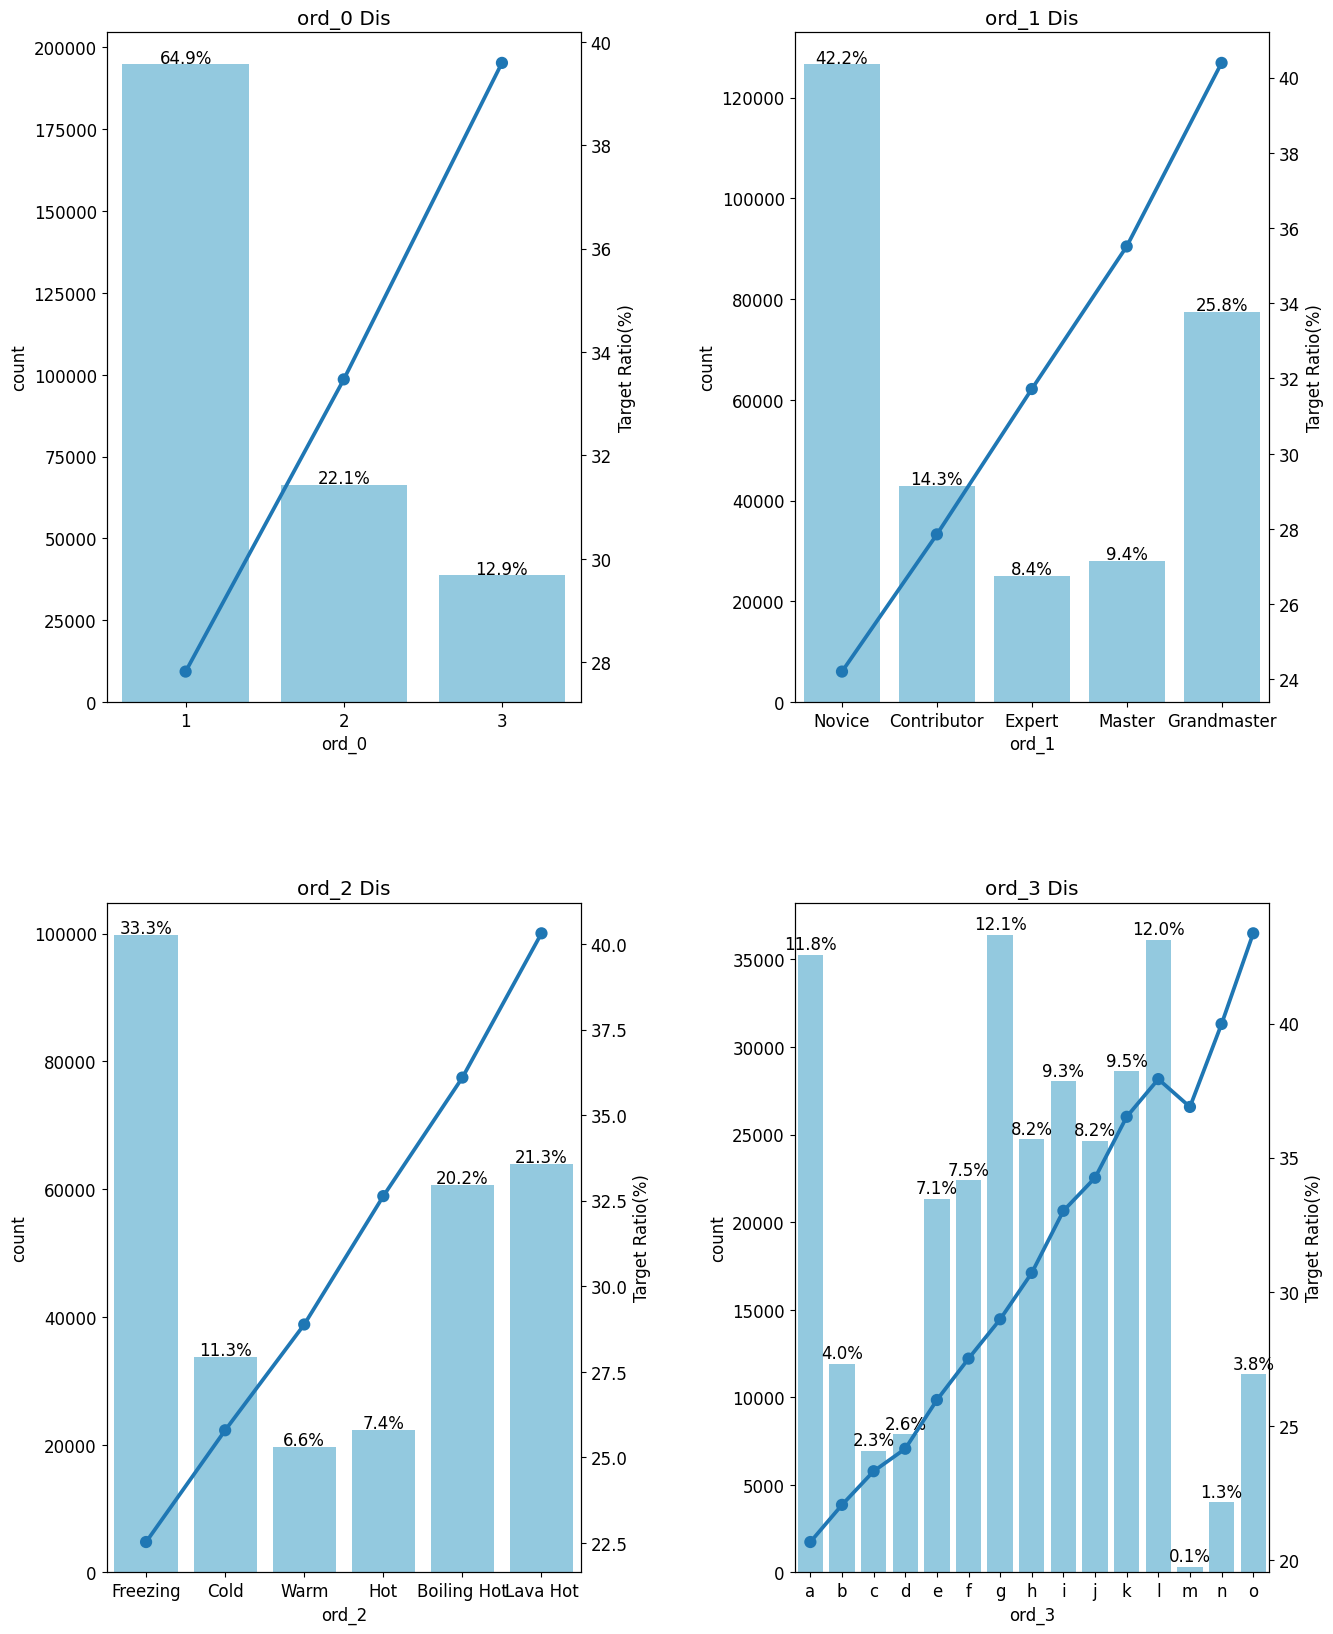

In [256]:
nom_feature = ['ord_0', 'ord_1', 'ord_2', 'ord_3']
plot_ratio(train, nom_feature, num_rows=2, num_cols=2)

<a name="날짜-피쳐"></a>
### 날짜 피쳐

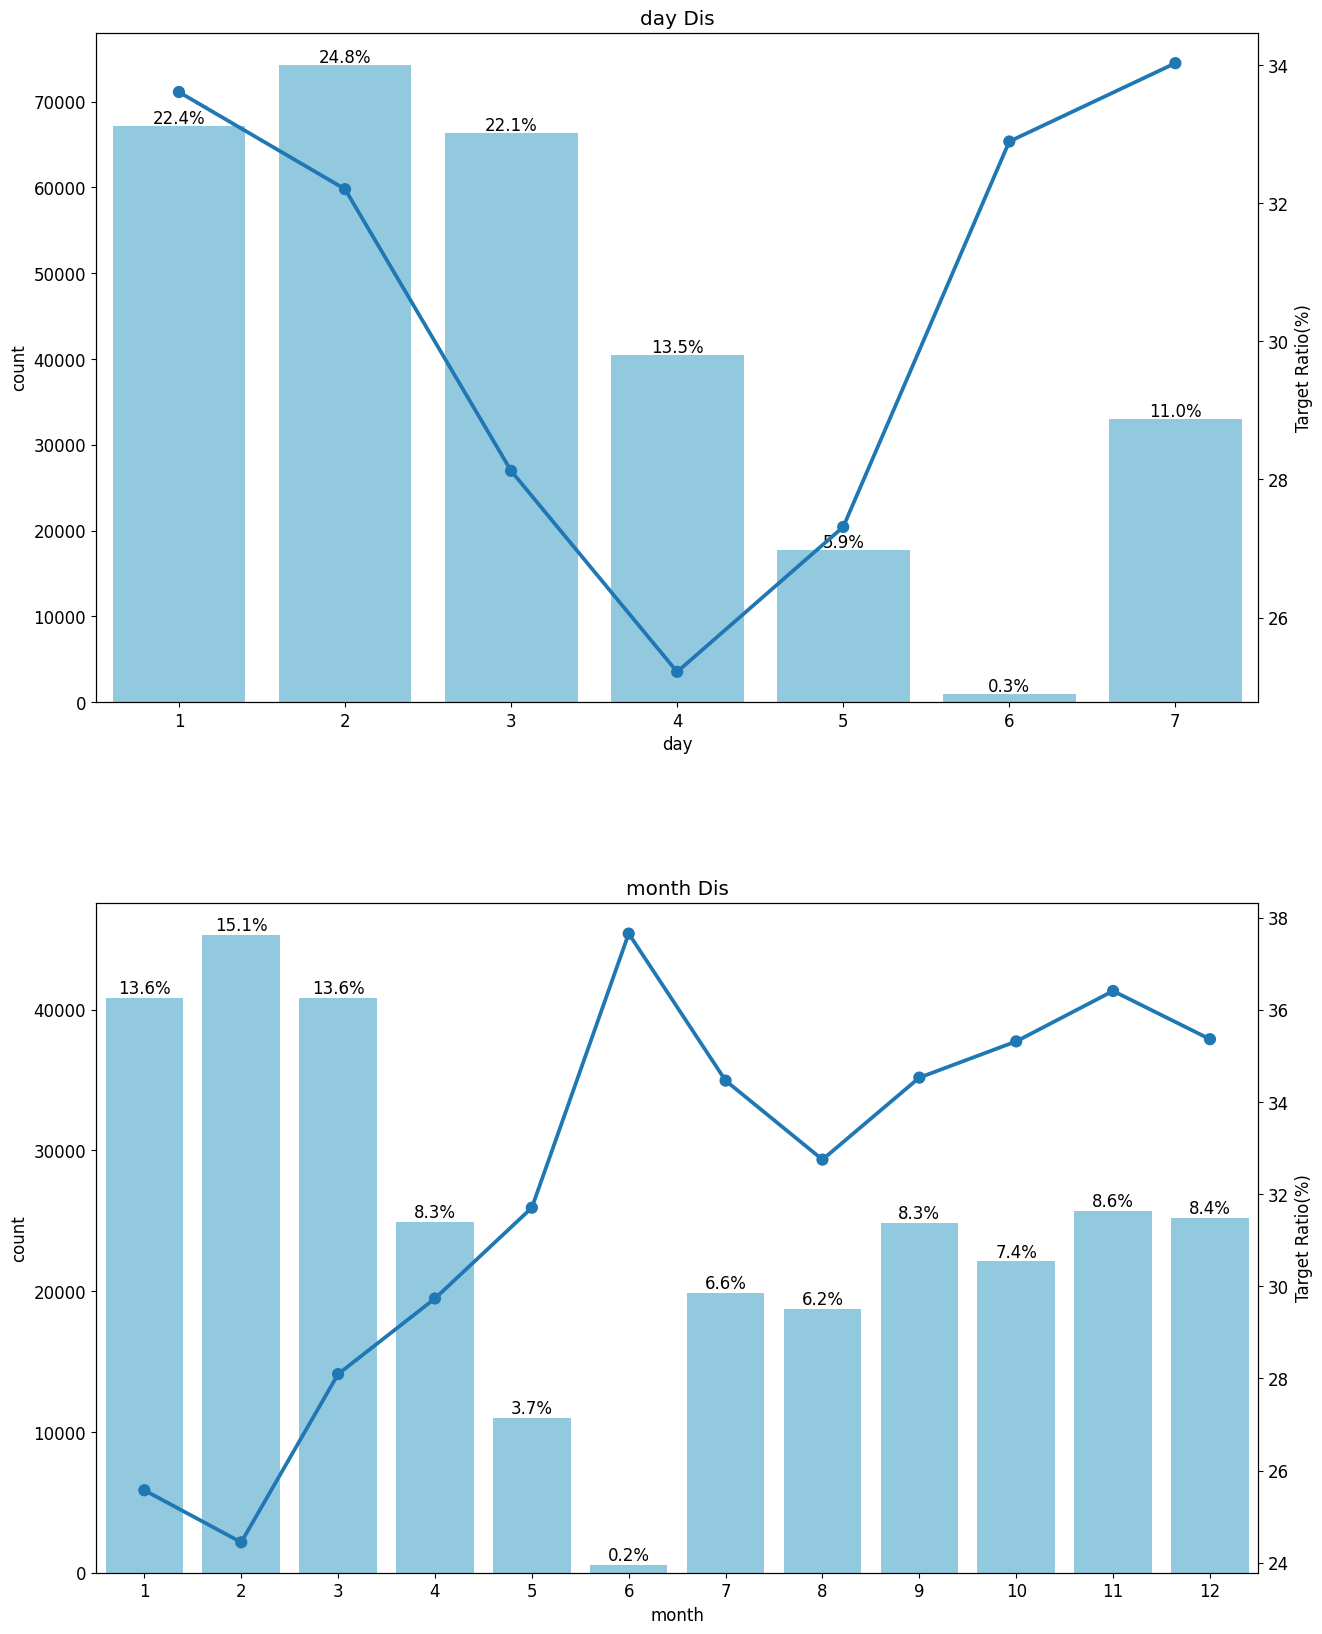

In [258]:
nom_feature = ['day', 'month']
plot_ratio(train, nom_feature, num_rows=2, num_cols=1)

<a name="3-베이스라인-모델"></a>
# 3. 베이스라인 모델

In [259]:
import pandas as pd

data_path = './dataset/cat-in-the-dat/'

train = pd.read_csv(data_path+'train.csv', index_col='id')
test = pd.read_csv(data_path+'test.csv', index_col='id')
submission = pd.read_csv(data_path+'sample_submission.csv', index_col='id')

<a name="31-피쳐-엔지니어링"></a>
## 3.1. 피쳐 엔지니어링

In [269]:
train_index = train.index
test_index = test.index

data = pd.concat([train,test])
data = data.drop(columns = ['target'])

In [272]:
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder()
encoded_data = OHE.fit_transform(data)
encoded_data

<500000x16552 sparse matrix of type '<class 'numpy.float64'>'
	with 11500000 stored elements in Compressed Sparse Row format>

In [279]:
from sklearn.model_selection import train_test_split

train_idx, valid_idx = train_test_split(train_index, test_size=0.2, stratify=train['target'])

<a name="32-모델-훈련"></a>
## 3.2. 모델 훈련

In [286]:
from sklearn.linear_model import LogisticRegression

logisticReg = LogisticRegression(max_iter=1000, random_state=0)
logisticReg.fit(encoded_data[train_idx], train.loc[train_idx]['target'])

LogisticRegression(max_iter=1000, random_state=0)

<a name="33-모델-성능-검증"></a>
## 3.3. 모델 성능 검증

In [293]:
valid_proba = logisticReg.predict_proba(encoded_data[valid_idx])[:,1]

In [298]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(train.loc[valid_idx]['target'], valid_proba)

In [297]:
roc_auc

0.7950861455874323

<a name="34-예측-및-결과-제출"></a>
## 3.4. 예측 및 결과 제출

In [312]:
train_proba = logisticReg.predict_proba(encoded_data[test_index])[:,1]

In [313]:
submission['target'] = train_proba

<a name="4-성능-개선-1"></a>
# 4. 성능 개선 1

In [365]:
import pandas as pd

data_path = './dataset/cat-in-the-dat/'

train = pd.read_csv(data_path+'train.csv', index_col='id')
test = pd.read_csv(data_path+'test.csv', index_col='id')
submission = pd.read_csv(data_path+'sample_submission.csv', index_col='id')

<a name="41-피쳐-엔지니어링-1--피쳐-맞춤-인코딩"></a>
## 4.1. 피쳐 엔지니어링 1 : 피쳐 맞춤 인코딩

In [366]:
train_index = train.index
test_index = test.index

data = pd.concat([train,test])
data = data.drop(columns = ['target'])

#### 이진 피쳐 인코딩

In [367]:
data['bin_3'] = data['bin_3'].map({'F': 0, 'T': 1})
data['bin_4'] = data['bin_4'].map({'N': 0, 'Y': 1})

#### 순서형 피쳐 인코딩

In [368]:
ord_1_dict = {'Novice':0, 'Contributor':1, 'Expert':2, 'Master':3, 'Grandmaster':4}
ord_2_dict = {'Freezing':0, 'Cold':1, 'Warm':2, 'Hot':3, 'Boiling Hot':4, 'Lava Hot':5}

data['ord_1'] = data['ord_1'].map(ord_1_dict)
data['ord_2'] = data['ord_2'].map(ord_2_dict)

In [370]:
from sklearn.preprocessing import OrdinalEncoder

ord_345 = ['ord_3','ord_4','ord_5']

OEn = OrdinalEncoder()
data[ord_345] = OEn.fit_transform(data[ord_345])

#### 명목형 피쳐 인코딩

In [376]:
nom_feat = ['nom_'+str(i) for i in range(10)]

from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder()
data_ = OHE.fit_transform(data[nom_feat])
data_

<500000x16276 sparse matrix of type '<class 'numpy.float64'>'
	with 5000000 stored elements in Compressed Sparse Row format>

In [380]:
data = data.drop(columns=nom_feat)

#### 날짜 피쳐 인코딩

In [379]:
data_feat = ['day', 'month']

from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder()
data__ = OHE.fit_transform(data[data_feat])
data__

<500000x19 sparse matrix of type '<class 'numpy.float64'>'
	with 1000000 stored elements in Compressed Sparse Row format>

In [381]:
data = data.drop(columns=data_feat)

<a name="42-피쳐-엔지니어링-2--피쳐-스케일링"></a>
## 4.2. 피쳐 엔지니어링 2 : 피쳐 스케일링

In [382]:
from sklearn.preprocessing import MinMaxScaler

ord_feat = ['ord_'+str(i) for i in range(6)]

data[ord_feat] = MinMaxScaler().fit_transform(data[ord_feat])

In [396]:
from scipy import sparse

data = sparse.hstack([data, data_,data__],format='csr')
data

<500000x16306 sparse matrix of type '<class 'numpy.float64'>'
	with 9163718 stored elements in Compressed Sparse Row format>

<a name="43-하이퍼파라미터-최적화"></a>
## 4.3. 하이퍼파라미터 최적화

In [398]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

LoReg = LogisticRegression()

params = {'C':[0.1,0.125,0.2], 'max_iter':[800,900,1000], 'solver':['liblinear'], 'random_state':[0]}
grid_LoReg = GridSearchCV(estimator=LoReg, param_grid=params, scoring='roc_auc',cv=5)

grid_LoReg.fit(encoded_data[train_idx], train.loc[train_idx]['target'])

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 0.125, 0.2], 'max_iter': [800, 900, 1000],
                         'random_state': [0], 'solver': ['liblinear']},
             scoring='roc_auc')

In [399]:
grid_LoReg.best_params_

{'C': 0.125, 'max_iter': 800, 'random_state': 0, 'solver': 'liblinear'}

<a name="44-모델-성능-검증"></a>
## 4.4. 모델 성능 검증

In [400]:
valid_pred = grid_LoReg.predict_proba(encoded_data[valid_idx])[:,1]

In [402]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(train.loc[valid_idx]['target'], valid_pred)

In [403]:
roc_auc

0.8018268698453632

<a name="45-예측-및-결과-제출"></a>
## 4.5. 예측 및 결과 제출

In [404]:
train_proba = logisticReg.predict_proba(encoded_data[test_index])[:,1]

In [405]:
submission['target'] = train_proba

<a name="5-성능-개선-2"></a>
# 5. 성능 개선 2

<a name="6-학습-마무리"></a>
# 6. 학습 마무리

<a name="61-핵심-요약"></a>
## 6.1. 핵심 요약